# Implementation of a KAN for regression
In this notebook I implement a Kolmogorov-Arnold Network (KAN) for the use of regression and compare it against a neural network of a similar architecture.

## Initialisations

In [1]:
!pip install pykan

In [2]:
import torch
from kan import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cpu


## Loading the Dataset

In [ ]:
def load_mercedes_dataset():
    # Load dataset from CSV file
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    # Identify categorical columns
    categorical_cols = train_data.select_dtypes(include=['object']).columns

    # Apply one-hot encoding to categorical columns
    encoder = OneHotEncoder(drop='first', sparse=False)
    train_encoded = encoder.fit_transform(train_data[categorical_cols])
    test_encoded = encoder.fit_transform(test_data[categorical_cols])

    # Drop original categorical columns and concatenate encoded columns
    train_data = train_data.drop(columns=categorical_cols).join(pd.DataFrame(train_encoded, index=train_data.index))
    test_data = test_data.drop(columns=categorical_cols).join(pd.DataFrame(test_encoded, index=test_data.index))

    # Separate features and target variable
    X = train_data.drop(columns=['y']).values
    y = train_data['y'].values

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Apply PCA to reduce to 8 dimensions
    pca = PCA(n_components=8)
    X_pca = pca.fit_transform(X)

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(X_pca, dtype=torch.float32)
    target_tensor = torch.tensor(y, dtype=torch.float32)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = DataLoader(TensorDataset(train_data, train_target), batch_size=1, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_data, test_target), batch_size=1, shuffle=False)

    # Move data to device and concatenate into a single tensor
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_inputs = torch.empty(0, train_data.shape[1], device=device)
    train_labels = torch.empty(0, dtype=torch.float32, device=device)
    test_inputs = torch.empty(0, test_data.shape[1], device=device)
    test_labels = torch.empty(0, dtype=torch.float32, device=device)

    for data, labels in tqdm(train_loader):
        train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

    for data, labels in tqdm(test_loader):
        test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels = torch.cat((test_labels, labels.to(device)), dim=0)

    dataset = {}
    dataset['train_input'] = train_inputs
    dataset['test_input'] = test_inputs
    dataset['train_label'] = train_labels.reshape(-1, 1)
    dataset['test_label'] = test_labels.reshape(-1, 1)

    return dataset

load_mercedes_dataset = load_mercedes_dataset()

In [ ]:
print("Train data shape: {}".format(load_mercedes_dataset['train_input'].shape))
print("Train target shape: {}".format(load_mercedes_dataset['train_label'].shape))
print("Test data shape: {}".format(load_mercedes_dataset['test_input'].shape))
print("Test target shape: {}".format(load_mercedes_dataset['test_label'].shape))


Train data shape: torch.Size([3367, 8])
Train target shape: torch.Size([3367, 1])
Test data shape: torch.Size([842, 8])
Test target shape: torch.Size([842, 1])


## Creating and Training the KAN

In [ ]:
image_folder = 'video_img'

model = KAN(width=[8, 3, 1], grid=10, k=3, seed=0, device=device)

In [ ]:
def train_mse():
    with torch.no_grad():
        predictions = model(load_mercedes_dataset['train_input'])
        mse = torch.nn.functional.mse_loss(predictions, load_mercedes_dataset['train_label'])
    return mse

def test_mse():
    with torch.no_grad():
        predictions = model(load_mercedes_dataset['test_input'])
        mse = torch.nn.functional.mse_loss(predictions, load_mercedes_dataset['test_label'])
    return mse

# Debugging: Print the shape of the tensors
print("Train input shape:", load_mercedes_dataset['train_input'].shape)
print("Train label shape:", load_mercedes_dataset['train_label'].shape)
print("Test input shape:", load_mercedes_dataset['test_input'].shape)
print("Test label shape:", load_mercedes_dataset['test_label'].shape)

# Ensure the model and dataset are on the same device
load_mercedes_dataset['train_input'] = load_mercedes_dataset['train_input'].to(device)
load_mercedes_dataset['train_label'] = load_mercedes_dataset['train_label'].to(device)
load_mercedes_dataset['test_input'] = load_mercedes_dataset['test_input'].to(device)
load_mercedes_dataset['test_label'] = load_mercedes_dataset['test_label'].to(device)
model = model.to(device)

results = model.train(load_mercedes_dataset, opt="LBFGS", device=device, metrics=(train_mse, test_mse),
                      loss_fn=torch.nn.MSELoss(), steps=25, lamb=0.01, lamb_entropy=2., save_fig=True, img_folder=image_folder)


Train input shape: torch.Size([3367, 8])
Train label shape: torch.Size([3367, 1])
Test input shape: torch.Size([842, 8])
Test label shape: torch.Size([842, 1])


train loss: 8.95e+00 | test loss: 1.04e+01 | reg: 1.65e+01 : 100%|██| 25/25 [02:40<00:00,  6.41s/it]


In [ ]:
print(results['train_mse'][-1], results['test_mse'][-1])

80.1102066040039 108.7791748046875


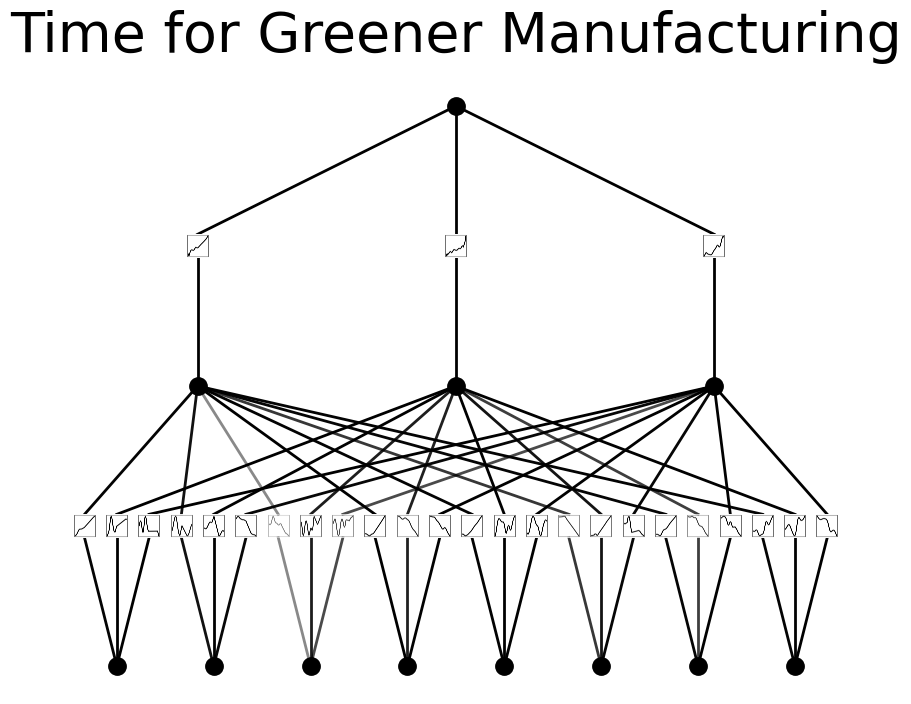

In [ ]:
model.plot(beta=50, scale=1, out_vars=['Time for Greener Manufacturing'])

In [ ]:
model.symbolic_formula()[0][0]

In [ ]:
import moviepy.video.io.ImageSequenceClip


video_name='video'
fps=10

fps = fps
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4


# Implementation of a Neural Network for comparison

## Misc Functions

In [ ]:
class CalHousNet(nn.Module):
    def __init__(self):
        super(CalHousNet, self).__init__()
        self.fc1 = nn.Linear(8, 3)  # 8 inputs to 5 hidden nodes
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(3, 1)  # 5 hidden nodes to 3 outputs

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=45):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

def test_model(model, test_loader):
    model.eval()
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            outputs = model(inputs)
            loss = torch.nn.functional.mse_loss(outputs, labels, reduction='sum')
            total_loss += loss.item()
            total_count += labels.size(0)

    # Calculate the average MSE over all batches
    average_mse = total_loss / total_count
    print(f'Mean Squared Error: {average_mse}')

In [ ]:
def load_load_mercedes_dataset():
    # Load dataset from CSV file
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    # Identify categorical columns
    categorical_cols = train_data.select_dtypes(include=['object']).columns

    # Apply one-hot encoding to categorical columns
    encoder = OneHotEncoder(drop='first', sparse=False)
    train_encoded = encoder.fit_transform(train_data[categorical_cols])
    test_encoded = encoder.fit_transform(test_data[categorical_cols])

    # Drop original categorical columns and concatenate encoded columns
    train_data = train_data.drop(columns=categorical_cols).join(pd.DataFrame(train_encoded, index=train_data.index))
    test_data = test_data.drop(columns=categorical_cols).join(pd.DataFrame(test_encoded, index=test_data.index))

    # Separate features and target variable
    X = train_data.drop(columns=['y']).values
    y = train_data['y'].values

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Apply PCA to reduce to 8 dimensions
    pca = PCA(n_components=8)
    X_pca = pca.fit_transform(X)

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(X_pca, dtype=torch.float32)
    target_tensor = torch.tensor(y, dtype=torch.float32)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=256, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=256, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_load_mercedes_dataset()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
train_loader = DataLoader(TensorDataset(load_mercedes_dataset['train_input'], load_mercedes_dataset['train_label']), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(load_mercedes_dataset['test_input'], load_mercedes_dataset['test_label']), batch_size=256, shuffle=False)


# Get a batch from train_loader and test_loader
dataiter = iter(train_loader)
data, labels = next(dataiter)
print("Train data shape: {}".format(data.shape))
print("Train target shape: {}".format(labels.shape))

dataiter = iter(test_loader)
data, labels = next(dataiter)
print("Test data shape: {}".format(data.shape))
print("Test target shape: {}".format(labels.shape))
print("====================================")


Train data shape: torch.Size([256, 8])
Train target shape: torch.Size([256, 1])
Test data shape: torch.Size([256, 8])
Test target shape: torch.Size([256, 1])


## Train and Evaluate the NN

In [ ]:
model = CalHousNet().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

train_model(model, train_loader, criterion, optimizer)

Epoch 1, Loss: 6963.67333984375
Epoch 2, Loss: 3662.9111328125
Epoch 3, Loss: 2185.246337890625
Epoch 4, Loss: 1665.8990478515625
Epoch 5, Loss: 888.969970703125
Epoch 6, Loss: 1006.7210693359375
Epoch 7, Loss: 645.5609741210938
Epoch 8, Loss: 432.7969665527344
Epoch 9, Loss: 359.6199951171875
Epoch 10, Loss: 429.5907897949219
Epoch 11, Loss: 558.434326171875
Epoch 12, Loss: 456.82647705078125
Epoch 13, Loss: 787.63818359375
Epoch 14, Loss: 972.8910522460938
Epoch 15, Loss: 414.3192138671875
Epoch 16, Loss: 283.438720703125
Epoch 17, Loss: 395.7186584472656
Epoch 18, Loss: 235.86355590820312
Epoch 19, Loss: 369.9621887207031
Epoch 20, Loss: 186.75241088867188
Epoch 21, Loss: 333.9786682128906
Epoch 22, Loss: 168.45364379882812
Epoch 23, Loss: 275.8766174316406
Epoch 24, Loss: 127.73199462890625
Epoch 25, Loss: 294.76531982421875
Epoch 26, Loss: 155.2678985595703
Epoch 27, Loss: 107.30392456054688
Epoch 28, Loss: 164.66778564453125
Epoch 29, Loss: 256.99127197265625
Epoch 30, Loss: 226.

In [ ]:
test_model(model, test_loader)

Mean Squared Error: 115.28991032326306
